# Data Cleaning & EDA
This notebook contains exploratory data analysis and the data cleaning involved.

In [136]:
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk

from sklearn.feature_extraction.text import CountVectorizer

In [176]:
### Read in variables from 01_Data_Collection
%store -r folk_artists
%store -r pop_artists
%store -r dance_artists

In [93]:
#read in the lyrics
lyrics = pd.read_csv('./all_lyrics.csv')

In [94]:
#read in the songs
songs = pd.read_csv('./all_songs.csv')

In [95]:
#check for nulls
songs.isnull().sum()

artist_name           0
image_url             0
url                   0
title                 0
lyrics               35
spotify_url        4099
billboard_genre       0
dtype: int64

In [96]:
#drop null lyrics
songs = songs.dropna(subset=['lyrics'])

### Create a new column in the DataFrames with cleaned lyrics

In [98]:
#Clean the song lyrics

def clean_song_lyrics(song_lyric):
    
    # 1. Remove HTML.
    lyrics_text = BeautifulSoup(song_lyric, "lxml").get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", lyrics_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Join the words back into one string separated by space 
    return(' '.join(words))

In [99]:
# Initialize an empty list to hold the clean lyrics.
clean_lyrics = []
clean_lyrics_songs = []

#loop through each lyric
for lyric in lyrics['lyrics']:
    
    # Convert lyrics to words, then append to clean_lyrics.
    clean_lyrics.append(clean_song_lyrics(lyric))

#loop through each song
for song in songs['lyrics']:
    
    # Convert lyrics to words, then append to clean_lyrics.
    clean_lyrics_songs.append(clean_song_lyrics(song))

In [34]:
#create a new column in lyrics
lyrics['clean_lyrics'] = clean_lyrics
lyrics.head()

,artist_name,lyrics,billboard_genre,clean_lyrics
0,Selena Gomez,You promised the world and I fell for it\nI pu...,pop,you promised the world and i fell for it i put...
1,​The Lumineers,"Ah, ah, when I was younger\nI, I should've kno...",folk_americana,ah ah when i was younger i i should ve known b...
2,Simon & Garfunkel,"Hello darkness, my old friend\nI've come to ta...",folk_americana,hello darkness my old friend i ve come to talk...
3,Mumford & Sons,Heto mi halanma\nMine waddimi yiddema\nKo ane ...,folk_americana,heto mi halanma mine waddimi yiddema ko ane ta...
4,Lord Huron,I am not the only traveler\nWho has not repaid...,folk_americana,i am not the only traveler who has not repaid ...


In [119]:
#create a new column in songs
songs['clean_lyrics'] = clean_lyrics_songs
songs.head()

,artist_name,image_url,url,title,lyrics,spotify_url,billboard_genre,clean_lyrics
0,Selena Gomez,https://images.genius.com/902d3ed593ed6f5e70ef...,https://genius.com/artists/Selena-gomez,Lose You To Love Me,You promised the world and I fell for it\nI pu...,https://open.spotify.com/track/1HfMVBKM75vxSfs...,pop,you promised the world and i fell for it i put...
1,Selena Gomez,https://images.genius.com/902d3ed593ed6f5e70ef...,https://genius.com/artists/Selena-gomez,Back to You,Took you like a shot\nThought that I could cha...,https://open.spotify.com/track/514rhnksEwHUh6L...,pop,took you like a shot thought that i could chas...
2,Selena Gomez,https://images.genius.com/902d3ed593ed6f5e70ef...,https://genius.com/artists/Selena-gomez,Fetish,Take it or leave it\nBaby take it or leave it\...,https://open.spotify.com/track/4lnAN2S1fcI0Sjx...,pop,take it or leave it baby take it or leave it b...
3,Selena Gomez,https://images.genius.com/902d3ed593ed6f5e70ef...,https://genius.com/artists/Selena-gomez,Bad Liar,I was walking down the street the other day\nT...,https://open.spotify.com/track/2fZQIJew3nkNe99...,pop,i was walking down the street the other day tr...
4,Selena Gomez,https://images.genius.com/902d3ed593ed6f5e70ef...,https://genius.com/artists/Selena-gomez,Look At Her Now,Yeah\n\nThey fell in love one summer\nA little...,NaN,pop,yeah they fell in love one summer a little too...


### Save as csv
(We will overwrite the previous all_lyrics.csv and all_songs.csv made in 01_Data_Collection)

In [103]:
#save as a csv
lyrics.to_csv('all_lyrics.csv', index=False)
songs.to_csv('all_songs.csv', index=False)

###  Create Artist sub-groups Dataframes
The function below will create a new dataframe with specified artist(s).

In [104]:
def new_artist_df(df, artist_list): #takes the dataframe and a list of artist_name strings
    
    #create a new dataframe with only the selected artist(s) 
    artists = '|'.join(artist_list)
    artists_df = df[df['artist_name'].str.contains(artists, regex=True)]
    
    return artists_df

In [36]:
# ex. only get John Mayer
new_artist_df(lyrics, ['John Mayer']).head()

,artist_name,lyrics,billboard_genre,clean_lyrics
22,John Mayer,"Ah, ah, ah\nAh...\n\nI'm the boy in your other...",folk_americana,ah ah ah ah i m the boy in your other phone li...


## Save as Text File
The file will be used for modeling with GPT-2.

In [114]:
#get a list of artist names
artist_names = [artist.strip() for artist in lyrics['artist_name']]

In [118]:
#using lyrics column because GPT-2 performs better this way.
for artist in artist_names:
    new_artist_df(lyrics, [artist])['lyrics'].to_csv(f"{artist.replace(' ','_')}.txt", header=False, index=False, sep='\t', mode='a')


## Find Most Frequent Words

In [141]:
#orders the occurrence of each word based on selected artist lyrics and can specify the range of tokens to group by.
def most_freq(df,ngram_range=(1,1),stopwords='english'):
    
    #instantiate CountVectorizer
    cvec_df = CountVectorizer(stop_words=stopwords,ngram_range=ngram_range)
    
    #select lyrics and fit
    X_series = df['clean_lyrics']
    X_series =  cvec_df.fit_transform(X_series)
    
    #convert to a dataframe
    X_df = pd.DataFrame(X_series.toarray(),
    columns=cvec_df.get_feature_names())
    
    # create empty dictionary
    top_words = {}

    # loop through columns
    for i in X_df.columns:
        # save sum of each column in dictionary
        top_words[i] =  X_df[i].sum()

    # top_words to dataframe sorted by highest occurance
    most_freq = pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True))
    
    return most_freq

In [142]:
# ex. get most frequent words for John Mayer
most_freq(new_artist_df(lyrics, ['John Mayer'])).head()

,0,1
0,love,301
1,just,221
2,oh,205
3,don,200
4,know,189


In [143]:
#Add additional stopwords
extra_stopwords = ['don','ll','ve']

#get the english stopwords
new_stopwords = nltk.corpus.stopwords.words('english')

#add our stopwords
new_stopwords.extend(extra_stopwords)

#Code adapted from Noah C at General Assembly

### Plot most frequent words

In [144]:
def plot_most_freq(df, num_words, artist_string):
    
    plt.figure(figsize=(20,8))
    plt.barh(df[0][:num_words], df[1][:num_words])
    plt.title(f'Most Frequent Words in {artist_string} Songs',fontsize=18)
    plt.gca().invert_yaxis(); #code adapted from https://stackoverflow.com/questions/34076177/matplotlib-horizontal-bar-chart-barh-is-upside-down 

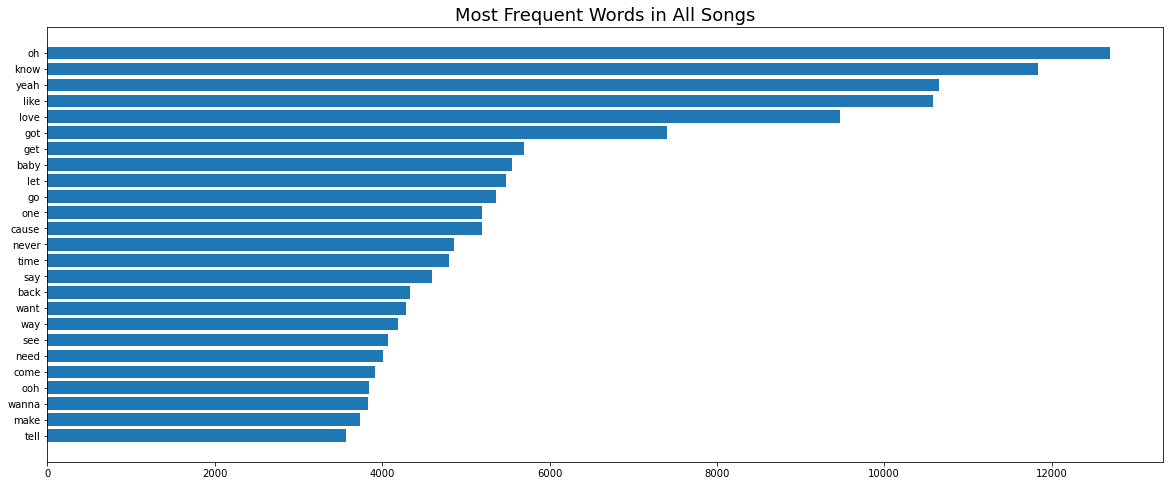

In [178]:
#Plot all Songs
plot_most_freq(most_freq(new_artist_df(lyrics, folk_artists + pop_artists),stopwords=new_stopwords), 
           num_words=25,
           artist_string='All')
plt.savefig('./imgs/freq_all.jpeg',bbox_inches='tight');

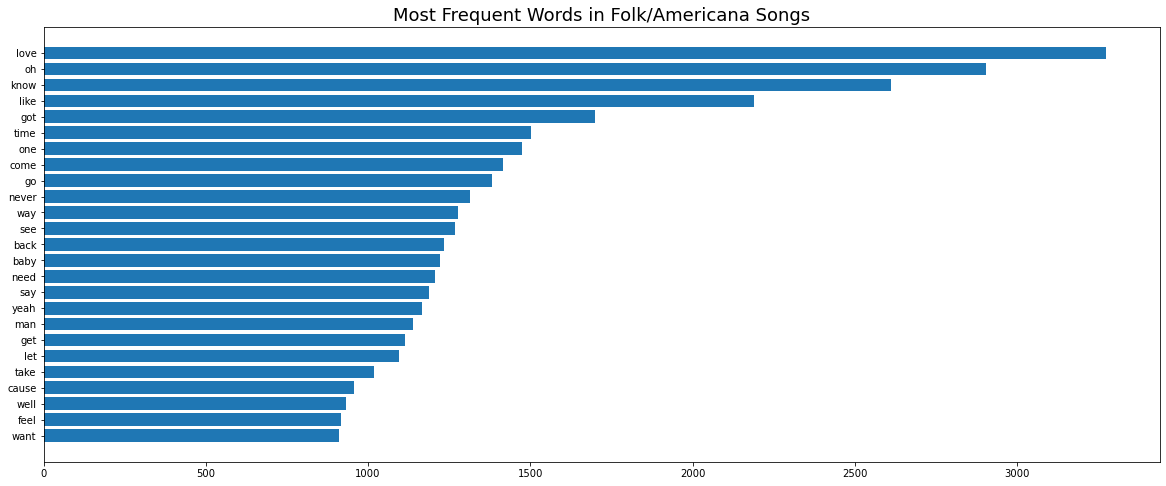

In [148]:
#Plot Folk/Americana Songs
plot_most_freq(most_freq(new_artist_df(lyrics, folk_artists),stopwords=new_stopwords), 
           num_words=25,
           artist_string='Folk/Americana')
plt.savefig('./imgs/freq_folk.jpeg',bbox_inches='tight');


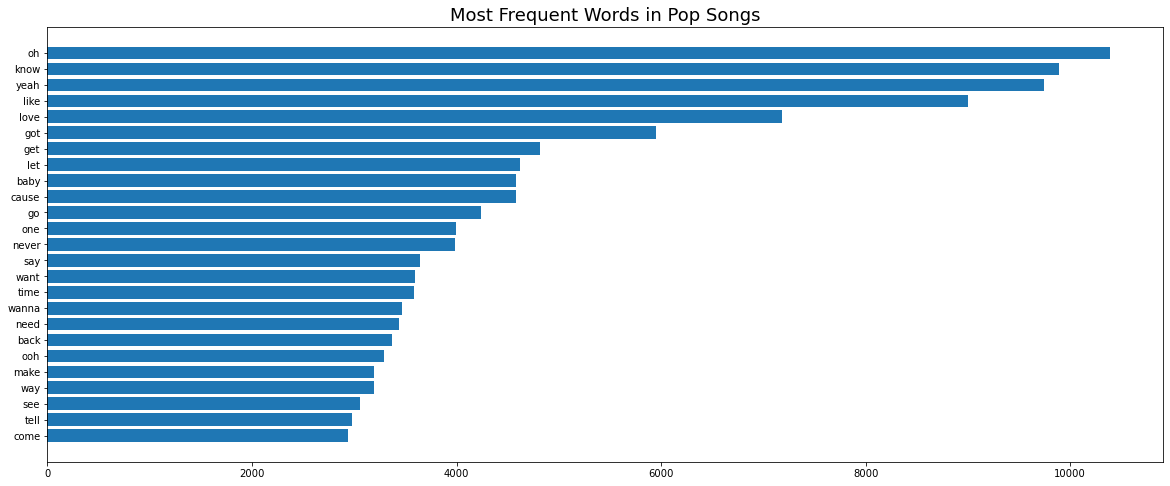

In [149]:
#Plot Pop Songs
plot_most_freq(most_freq(new_artist_df(lyrics, pop_artists),stopwords=new_stopwords), 
           num_words=25,
           artist_string='Pop')
plt.savefig('./imgs/freq_pop.jpeg',bbox_inches='tight');


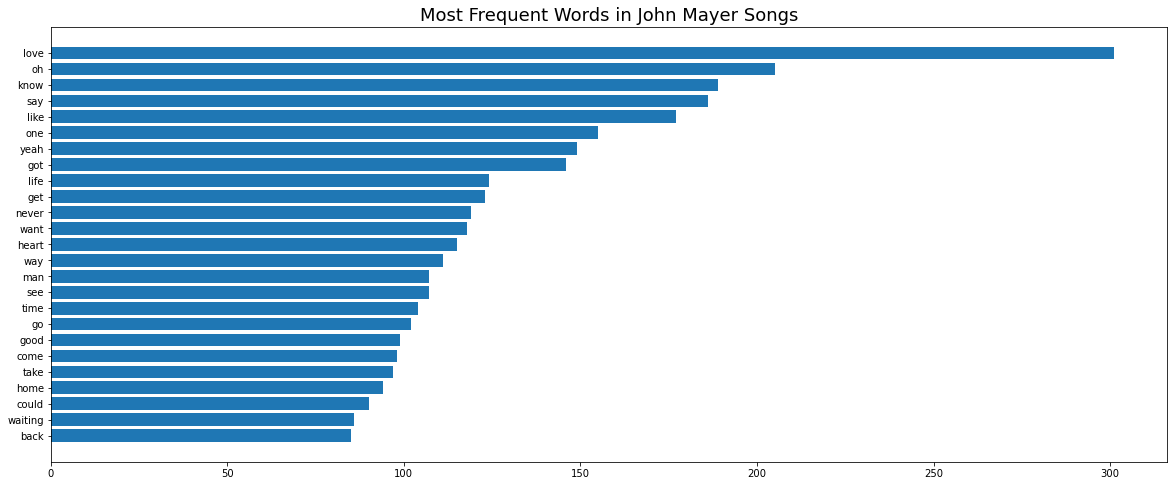

In [150]:
#Plot John Mayer
plot_most_freq(most_freq(new_artist_df(lyrics, ['John Mayer']),stopwords=new_stopwords), 
           num_words=25,
           artist_string='John Mayer')
plt.savefig('./imgs/freq_john_mayer.jpeg',bbox_inches='tight');


### What words are unique and similar to pop songs and folk/americana songs?

In [171]:
#Find unique
top_25_pop = list(most_freq(new_artist_df(lyrics, pop_artists),stopwords=new_stopwords)[:25][0])
top_25_folk = list(most_freq(new_artist_df(lyrics, folk_artists),stopwords=new_stopwords)[:25][0])

In [173]:
#similar words
set(top_25_folk).intersection(set(top_25_pop))

{'baby',
 'back',
 'cause',
 'come',
 'get',
 'go',
 'got',
 'know',
 'let',
 'like',
 'love',
 'need',
 'never',
 'oh',
 'one',
 'say',
 'see',
 'time',
 'want',
 'way',
 'yeah'}

In [174]:
#Unique words to Folk/Americana
set(top_25_folk).difference(set(top_25_pop))

{'feel', 'man', 'take', 'well'}

In [175]:
#Unique words to Pop
set(top_25_pop).difference(set(top_25_folk))

{'make', 'ooh', 'tell', 'wanna'}

## Find Bi and Tri-Grams out of all songs

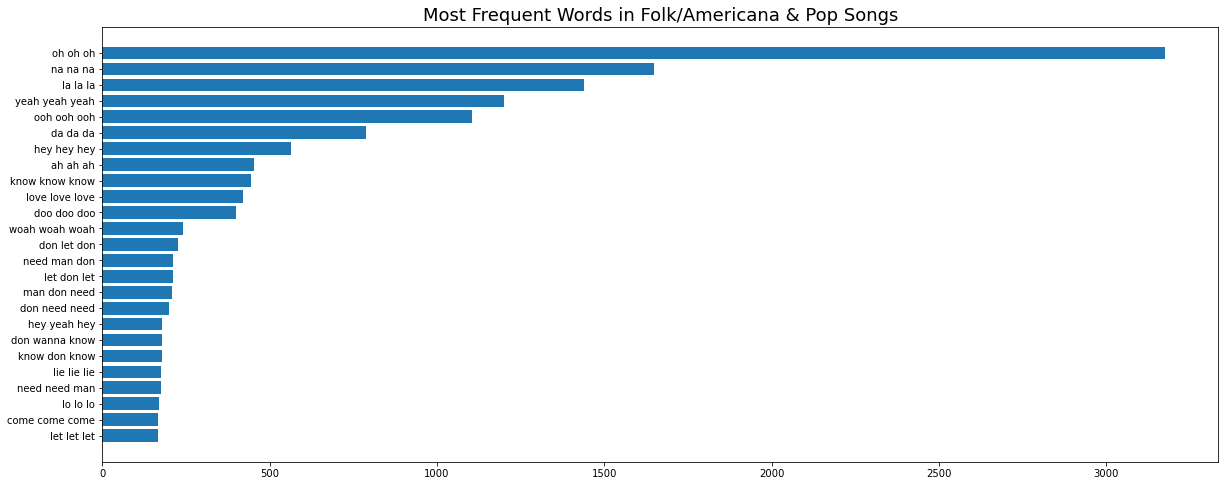

In [152]:
plot_most_freq(most_freq(lyrics, ngram_range=(3,3)), 
           num_words=25,
           artist_string='Folk/Americana & Pop')
plt.savefig('./imgs/freq_tri_gram.jpeg',bbox_inches='tight');

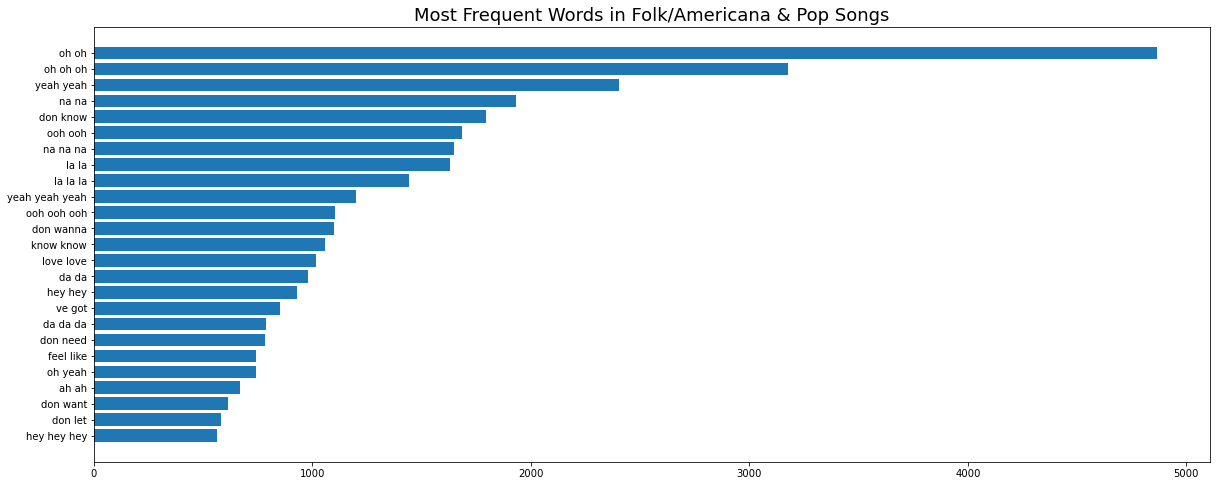

In [80]:
plot_most_freq(most_freq(lyrics, ngram_range=(2,3)), 
           num_words=25,
           artist_string='Folk/Americana & Pop')
plt.savefig('./imgs/freq__bi_tri_gram.jpeg',bbox_inches='tight');

## Bi and Tri-Grams of John Mayer Songs

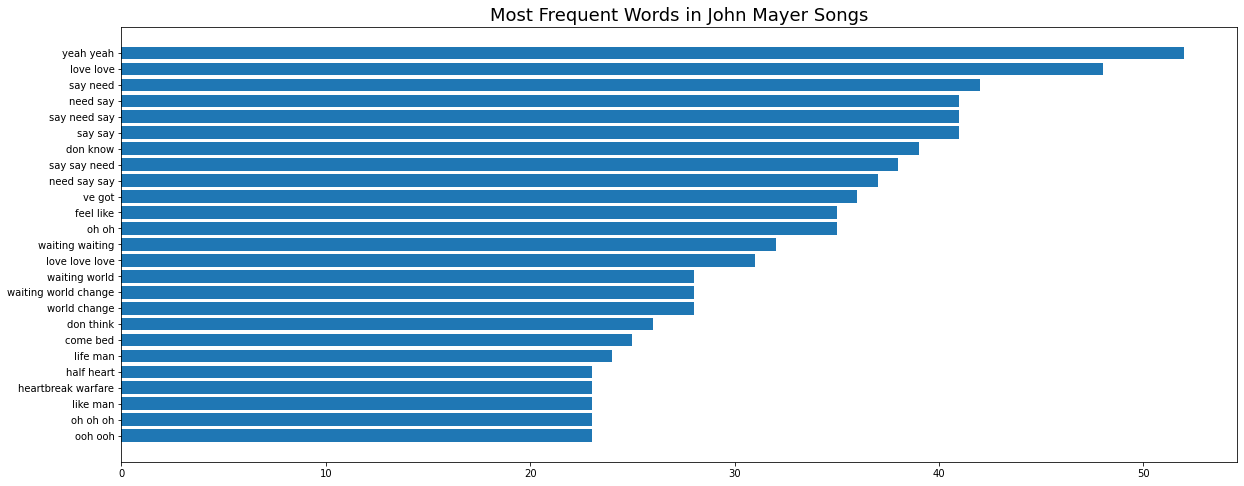

In [183]:
plot_most_freq(most_freq(new_artist_df(lyrics, ['John Mayer']), ngram_range=(2,3)), 
           num_words=25,
           artist_string='John Mayer')
plt.savefig('./imgs/freq__bi_tri_gram_john.jpeg',bbox_inches='tight');